In [1]:
# dependencies
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import cPickle as pickle
from collections import Counter


In [2]:
#dataRead

en_sentences = []
es_sentences = []

for i in range(4):
    with open("dataset/europarl-v7.es-en-" + str(i) +".en", 'r') as en_file:
        for en_line in en_file:
            en_sentences.append(en_line)
    print "readed en" + str(i)
    with open("dataset/europarl-v7.es-en-" + str(i) +".es", 'r') as es_file:
        for es_line in es_file:
            es_sentences.append(es_line)
    print "readed es" + str(i)

readed en0
readed es0
readed en1
readed es1
readed en2
readed es2
readed en3
readed es3


In [3]:
index = 999999
print en_sentences[index]
print es_sentences[index]

Apart from anything else, they divisively create social problems for workers in the shipping industry and residents of island regions.

Aparte de todo, crean, generando discrepancias, problemas sociales para los trabajadores del sector naviero y los residentes de las regiones insulares.



In [4]:
#DataPreparation
def create_dataset(source_sentences,target_sentences):
    source_vocab_dict = Counter(word.strip(',." ;:)(][?!') for sentence in source_sentences for word in sentence.split())
    target_vocab_dict = Counter(word.strip(',." ;:)(][?!') for sentence in target_sentences for word in sentence.split())

    source_vocab = map(lambda x: x[0], sorted(source_vocab_dict.items(), key = lambda x: -x[1]))
    target_vocab = map(lambda x: x[0], sorted(target_vocab_dict.items(), key = lambda x: -x[1]))
    
    source_vocab = source_vocab[:20000]
    target_vocab = target_vocab[:30000]
    
    start_idx = 2
    source_word2idx = dict([(word, idx+start_idx) for idx, word in enumerate(source_vocab)])
    source_word2idx['<ukn>'] = 0
    source_word2idx['<pad>'] = 1
    source_idx2word = dict([(idx, word) for word, idx in source_word2idx.iteritems()])
    
    start_idx = 4
    target_word2idx = dict([(word, idx+start_idx) for idx, word in enumerate(target_vocab)])
    target_word2idx['<ukn>'] = 0
    target_word2idx['<go>']  = 1
    target_word2idx['<eos>'] = 2
    target_word2idx['<pad>'] = 3
    
    target_idx2word = dict([(idx, word) for word, idx in target_word2idx.iteritems()])
    x = [[source_word2idx.get(word.strip(',." ;:)(][?!'), 0) for word in sentence.split()] for sentence in source_sentences]
    y = [[target_word2idx.get(word.strip(',." ;:)(][?!'), 0) for word in sentence.split()] for sentence in target_sentences]
    
    X = []
    Y = []
    
    for i in range(len(x)):
        n1 = len(x[i])
        n2 = len(y[i])
        n = n1 if n1 < n2 else n2 
        if abs(n1 - n2) <= 0.3 * n:
            if n1 <= 15 and n2 <= 15:
                X.append(x[i])
                Y.append(y[i])
    return X, Y, source_word2idx, source_idx2word, source_vocab, target_word2idx, target_idx2word, target_vocab

def save_dataset(file_path, obj):
    with open(file_path, 'wb') as f:
        pickle.dump(obj, f, -1)

def read_dataset(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

In [5]:
#en_sentences = ['hello my friend', 'we need to reboot the server']
#es_sentences = ['hola mi amigo', 'necesitamos reiniciar el servidor']
save_dataset('./data.pkl', create_dataset(en_sentences, es_sentences))

In [6]:
# read dataset
X, Y, en_word2idx, en_idx2word, en_vocab, es_word2idx, es_idx2word, es_vocab = read_dataset('data.pkl')

In [7]:
print X

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
#CHECK THAT WORKs
print 'Sentence in English - encoded:', X[0]
print 'Sentence in Spanish - encoded:', Y[0]
print 'Decoded:\n------------------------'

for i in range(len(X[0])):
    print en_idx2word[X[0][i]],
    
print '\n'

for i in range(len(Y[0])):
    print es_idx2word[Y[0][i]],

Sentence in English - encoded: [8425, 3, 2, 1695]
Sentence in Spanish - encoded: [10624, 13, 575, 4, 1420]
Decoded:
------------------------
Resumption of the session 

Reanudación del período de sesiones


In [9]:
# data processing

# data padding
def data_padding(x, y, length = 15):
    for i in range(len(x)):
        x[i] = x[i] + (length - len(x[i])) * [en_word2idx['<pad>']]
        y[i] = [es_word2idx['<go>']] + y[i] + [es_word2idx['<eos>']] + (length-len(y[i])) * [es_word2idx['<pad>']]

data_padding(X, Y)
print X

# data splitting
X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

del X
del Y

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
# build a model

input_seq_len = 15
output_seq_len = 17
en_vocab_size = len(en_vocab) + 2 # + <pad>, <ukn>
es_vocab_size = len(es_vocab) + 4 # + <pad>, <ukn>, <eos>, <go>

# placeholders
encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

targets = [decoder_inputs[i+1] for i in range(output_seq_len-1)]
# add one more target
targets.append(tf.placeholder(dtype = tf.int32, shape = [None], name = 'last_target'))
target_weights = [tf.placeholder(dtype = tf.float32, shape = [None], name = 'target_w{}'.format(i)) for i in range(output_seq_len)]

# output projection
size = 512
w_t = tf.get_variable('proj_w', [es_vocab_size, size], tf.float32)
b = tf.get_variable('proj_b', [es_vocab_size], tf.float32)
w = tf.transpose(w_t)
output_projection = (w, b)

outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                            encoder_inputs,
                                            decoder_inputs,
                                            tf.contrib.rnn.BasicLSTMCell(size),
                                            num_encoder_symbols = en_vocab_size,
                                            num_decoder_symbols = es_vocab_size,
                                            embedding_size = 100,
                                            feed_previous = False,
                                            output_projection = output_projection,
                                            dtype = tf.float32)

In [11]:
# define our loss function

# sampled softmax loss - returns: A batch_size 1-D tensor of per-example sampled softmax losses
def sampled_loss(labels, logits):
    return tf.nn.sampled_softmax_loss(
                        weights = w_t,
                        biases = b,
                        labels = tf.reshape(labels, [-1, 1]),
                        inputs = logits,
                        num_sampled = 512,
                        num_classes = es_vocab_size)

# Weighted cross-entropy loss for a sequence of logits
loss = tf.contrib.legacy_seq2seq.sequence_loss(outputs, targets, target_weights, softmax_loss_function = sampled_loss)

In [12]:
# let's define some helper functions

# simple softmax function
def softmax(x):
    n = np.max(x)
    e_x = np.exp(x - n)
    return e_x / e_x.sum()

# feed data into placeholders
def feed_dict(x, y, batch_size = 64):
    feed = {}
    
    idxes = np.random.choice(len(x), size = batch_size, replace = False)
    
    for i in range(input_seq_len):
        feed[encoder_inputs[i].name] = np.array([x[j][i] for j in idxes], dtype = np.int32)
        
    for i in range(output_seq_len):
        feed[decoder_inputs[i].name] = np.array([y[j][i] for j in idxes], dtype = np.int32)
        
    feed[targets[len(targets)-1].name] = np.full(shape = [batch_size], fill_value = es_word2idx['<pad>'], dtype = np.int32)
    
    for i in range(output_seq_len-1):
        batch_weights = np.ones(batch_size, dtype = np.float32)
        target = feed[decoder_inputs[i+1].name]
        for j in range(batch_size):
            if target[j] == es_word2idx['<pad>']:
                batch_weights[j] = 0.0
        feed[target_weights[i].name] = batch_weights
        
    feed[target_weights[output_seq_len-1].name] = np.zeros(batch_size, dtype = np.float32)
    
    return feed

# decode output sequence
def decode_output(output_seq):
    words = []
    for i in range(output_seq_len):
        smax = softmax(output_seq[i])
        idx = np.argmax(smax)
        words.append(es_idx2word[idx])
    return words

In [13]:
# ops and hyperparameters
learning_rate = 5e-3
batch_size = 64
steps = 10000

# ops for projecting outputs
outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

# training op
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# init op
init = tf.global_variables_initializer()

# forward step
def forward_step(sess, feed):
    output_sequences = sess.run(outputs_proj, feed_dict = feed)
    return output_sequences

# training step
def backward_step(sess, feed):
    sess.run(optimizer, feed_dict = feed)

In [14]:
print X_train

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
# let's train the model

# we will use this list to plot losses through steps
losses = []

# save a checkpoint so we can restore the model later 
saver = tf.train.Saver()

print '------------------TRAINING------------------'

with tf.Session() as sess:
    sess.run(init)
    
    t = time.time()
    for step in range(steps):
        feed = feed_dict(X_train, Y_train)
            
        backward_step(sess, feed)
        
        if step % 5 == 4 or step == 0:
            loss_value = sess.run(loss, feed_dict = feed)
            print 'step: {}, loss: {}'.format(step, loss_value)
            losses.append(loss_value)
        
        if step % 20 == 19:
            saver.save(sess, 'checkpoints/', global_step=step)
            print 'Checkpoint is saved'
            
    print 'Training time for {} steps: {}s'.format(steps, time.time() - t)

------------------TRAINING------------------
step: 0, loss: 8.9650554657
step: 4, loss: 9.09259319305
step: 9, loss: 8.96600341797
step: 14, loss: 9.08163356781
step: 19, loss: 9.04584121704
Checkpoint is saved
step: 24, loss: 8.9775428772
step: 29, loss: 8.96202087402
step: 34, loss: 9.04169273376
step: 39, loss: 8.95137405396
Checkpoint is saved
step: 44, loss: 8.84370326996
step: 49, loss: 8.92049789429
step: 54, loss: 8.74224281311
step: 59, loss: 8.30894088745
Checkpoint is saved
step: 64, loss: 7.69854354858
step: 69, loss: 6.97393226624
step: 74, loss: 7.30864953995
step: 79, loss: 6.32648658752
Checkpoint is saved
step: 84, loss: 6.11800193787
step: 89, loss: 6.25610637665
step: 94, loss: 6.08073997498
step: 99, loss: 6.0511264801
Checkpoint is saved
step: 104, loss: 6.38327121735
step: 109, loss: 5.84017515182
step: 114, loss: 5.84495449066
step: 119, loss: 5.73464488983
Checkpoint is saved
step: 124, loss: 5.48550701141
step: 129, loss: 5.4876832962
step: 134, loss: 5.9577622

step: 1139, loss: 1.01748478413
Checkpoint is saved
step: 1144, loss: 1.16948473454
step: 1149, loss: 1.19262623787
step: 1154, loss: 1.06632900238
step: 1159, loss: 1.20566475391
Checkpoint is saved
step: 1164, loss: 1.260160923
step: 1169, loss: 1.1423137188
step: 1174, loss: 1.12538409233
step: 1179, loss: 0.951745986938
Checkpoint is saved
step: 1184, loss: 1.10071599483
step: 1189, loss: 1.23123860359
step: 1194, loss: 1.28469920158
step: 1199, loss: 1.06936144829
Checkpoint is saved
step: 1204, loss: 1.14399838448
step: 1209, loss: 0.9406504035
step: 1214, loss: 1.11304366589
step: 1219, loss: 1.05500853062
Checkpoint is saved
step: 1224, loss: 1.23689055443
step: 1229, loss: 1.10858821869
step: 1234, loss: 1.08985579014
step: 1239, loss: 1.02006995678
Checkpoint is saved
step: 1244, loss: 1.10317599773
step: 1249, loss: 0.88196849823
step: 1254, loss: 1.03918588161
step: 1259, loss: 1.03878998756
Checkpoint is saved
step: 1264, loss: 1.03968441486
step: 1269, loss: 0.95664614439

step: 2229, loss: 0.758251368999
step: 2234, loss: 0.848917841911
step: 2239, loss: 0.770509541035
Checkpoint is saved
step: 2244, loss: 0.752563357353
step: 2249, loss: 0.728128612041
step: 2254, loss: 0.742596507072
step: 2259, loss: 0.757927536964
Checkpoint is saved
step: 2264, loss: 0.787601351738
step: 2269, loss: 0.654601573944
step: 2274, loss: 0.813274979591
step: 2279, loss: 0.719276428223
Checkpoint is saved
step: 2284, loss: 0.70891970396
step: 2289, loss: 0.527855038643
step: 2294, loss: 0.691080212593
step: 2299, loss: 0.747519493103
Checkpoint is saved
step: 2304, loss: 0.852898955345
step: 2309, loss: 0.805727481842
step: 2314, loss: 0.707306265831
step: 2319, loss: 0.63568842411
Checkpoint is saved
step: 2324, loss: 0.782061338425
step: 2329, loss: 0.97177284956
step: 2334, loss: 0.79211306572
step: 2339, loss: 0.749987840652
Checkpoint is saved
step: 2344, loss: 0.68276655674
step: 2349, loss: 0.685160577297
step: 2354, loss: 0.694991111755
step: 2359, loss: 0.7558851

step: 3314, loss: 0.572088837624
step: 3319, loss: 0.568711996078
Checkpoint is saved
step: 3324, loss: 0.60239136219
step: 3329, loss: 0.642002165318
step: 3334, loss: 0.679989099503
step: 3339, loss: 0.702555060387
Checkpoint is saved
step: 3344, loss: 0.636394202709
step: 3349, loss: 0.566143870354
step: 3354, loss: 0.521510481834
step: 3359, loss: 0.580823302269
Checkpoint is saved
step: 3364, loss: 0.662432670593
step: 3369, loss: 0.601620435715
step: 3374, loss: 0.522187232971
step: 3379, loss: 0.584721744061
Checkpoint is saved
step: 3384, loss: 0.505610227585
step: 3389, loss: 0.646488785744
step: 3394, loss: 0.607615053654
step: 3399, loss: 0.665447413921
Checkpoint is saved
step: 3404, loss: 0.605726242065
step: 3409, loss: 0.570219099522
step: 3414, loss: 0.583872199059
step: 3419, loss: 0.63631439209
Checkpoint is saved
step: 3424, loss: 0.678439617157
step: 3429, loss: 0.519179522991
step: 3434, loss: 0.656097352505
step: 3439, loss: 0.547735989094
Checkpoint is saved
step

step: 4399, loss: 0.505971431732
Checkpoint is saved
step: 4404, loss: 0.793555378914
step: 4409, loss: 0.572595596313
step: 4414, loss: 0.601051092148
step: 4419, loss: 0.623666644096
Checkpoint is saved
step: 4424, loss: 0.606485009193
step: 4429, loss: 0.544421195984
step: 4434, loss: 0.585327506065
step: 4439, loss: 0.552182555199
Checkpoint is saved
step: 4444, loss: 0.565583646297
step: 4449, loss: 0.40988856554
step: 4454, loss: 0.467222541571
step: 4459, loss: 0.526784062386
Checkpoint is saved
step: 4464, loss: 0.540553569794
step: 4469, loss: 0.59456461668
step: 4474, loss: 0.534188807011
step: 4479, loss: 0.490632265806
Checkpoint is saved
step: 4484, loss: 0.448954820633
step: 4489, loss: 0.563126683235
step: 4494, loss: 0.502766907215
step: 4499, loss: 0.445716947317
Checkpoint is saved
step: 4504, loss: 0.58954757452
step: 4509, loss: 0.704829990864
step: 4514, loss: 0.430272072554
step: 4519, loss: 0.525730609894
Checkpoint is saved
step: 4524, loss: 0.369942545891
step:

Checkpoint is saved
step: 5484, loss: 0.606736898422
step: 5489, loss: 0.524172067642
step: 5494, loss: 0.505207419395
step: 5499, loss: 0.535045742989
Checkpoint is saved
step: 5504, loss: 0.502351760864
step: 5509, loss: 0.403441429138
step: 5514, loss: 0.553533315659
step: 5519, loss: 0.592334449291
Checkpoint is saved
step: 5524, loss: 0.569378256798
step: 5529, loss: 0.605040132999
step: 5534, loss: 0.538051843643
step: 5539, loss: 0.432314276695
Checkpoint is saved
step: 5544, loss: 0.531026780605
step: 5549, loss: 0.578982114792
step: 5554, loss: 0.483246684074
step: 5559, loss: 0.466720581055
Checkpoint is saved
step: 5564, loss: 0.403963565826
step: 5569, loss: 0.517579376698
step: 5574, loss: 0.509555101395
step: 5579, loss: 0.498215079308
Checkpoint is saved
step: 5584, loss: 0.449390619993
step: 5589, loss: 0.47673946619
step: 5594, loss: 0.547104477882
step: 5599, loss: 0.525807976723
Checkpoint is saved
step: 5604, loss: 0.575943052769
step: 5609, loss: 0.498561024666
ste

step: 6564, loss: 0.50758087635
step: 6569, loss: 0.474574834108
step: 6574, loss: 0.584380149841
step: 6579, loss: 0.57367181778
Checkpoint is saved
step: 6584, loss: 0.467821657658
step: 6589, loss: 0.418170899153
step: 6594, loss: 0.489863157272
step: 6599, loss: 0.468178510666
Checkpoint is saved
step: 6604, loss: 0.565271496773
step: 6609, loss: 0.51308298111
step: 6614, loss: 0.591257452965
step: 6619, loss: 0.611610770226
Checkpoint is saved
step: 6624, loss: 0.478917509317
step: 6629, loss: 0.544191718102
step: 6634, loss: 0.460880637169
step: 6639, loss: 0.547163426876
Checkpoint is saved
step: 6644, loss: 0.469384670258
step: 6649, loss: 0.517069458961
step: 6654, loss: 0.449423015118
step: 6659, loss: 0.542931735516
Checkpoint is saved
step: 6664, loss: 0.454904973507
step: 6669, loss: 0.539228320122
step: 6674, loss: 0.456863850355
step: 6679, loss: 0.550505757332
Checkpoint is saved
step: 6684, loss: 0.446848541498
step: 6689, loss: 0.515272498131
step: 6694, loss: 0.45995

step: 7649, loss: 0.415870636702
step: 7654, loss: 0.463086366653
step: 7659, loss: 0.446862488985
Checkpoint is saved
step: 7664, loss: 0.47581627965
step: 7669, loss: 0.423181831837
step: 7674, loss: 0.429022669792
step: 7679, loss: 0.429570317268
Checkpoint is saved
step: 7684, loss: 0.433787405491
step: 7689, loss: 0.568915963173
step: 7694, loss: 0.495822250843
step: 7699, loss: 0.425463974476
Checkpoint is saved
step: 7704, loss: 0.467108368874
step: 7709, loss: 0.512805342674
step: 7714, loss: 0.504407346249
step: 7719, loss: 0.459614634514
Checkpoint is saved
step: 7724, loss: 0.535427808762
step: 7729, loss: 0.485875189304
step: 7734, loss: 0.47445705533
step: 7739, loss: 0.546576023102
Checkpoint is saved
step: 7744, loss: 0.431714653969
step: 7749, loss: 0.4830108881
step: 7754, loss: 0.404764860868
step: 7759, loss: 0.496067404747
Checkpoint is saved
step: 7764, loss: 0.436010599136
step: 7769, loss: 0.444344103336
step: 7774, loss: 0.617556452751
step: 7779, loss: 0.421294

step: 8734, loss: 0.422891497612
step: 8739, loss: 0.459006428719
Checkpoint is saved
step: 8744, loss: 0.53845179081
step: 8749, loss: 0.546643137932
step: 8754, loss: 0.520439326763
step: 8759, loss: 0.437934219837
Checkpoint is saved
step: 8764, loss: 0.510752081871
step: 8769, loss: 0.498391389847
step: 8774, loss: 0.558626651764
step: 8779, loss: 0.435430049896
Checkpoint is saved
step: 8784, loss: 0.365146934986
step: 8789, loss: 0.487807422876
step: 8794, loss: 0.450491935015
step: 8799, loss: 0.42739841342
Checkpoint is saved
step: 8804, loss: 0.51668292284
step: 8809, loss: 0.484479188919
step: 8814, loss: 0.510768294334
step: 8819, loss: 0.496273964643
Checkpoint is saved
step: 8824, loss: 0.453173726797
step: 8829, loss: 0.467524796724
step: 8834, loss: 0.437727808952
step: 8839, loss: 0.432397931814
Checkpoint is saved
step: 8844, loss: 0.444600313902
step: 8849, loss: 0.503513276577
step: 8854, loss: 0.404534459114
step: 8859, loss: 0.371380031109
Checkpoint is saved
step:

step: 9819, loss: 0.444146215916
Checkpoint is saved
step: 9824, loss: 0.49671292305
step: 9829, loss: 0.44187349081
step: 9834, loss: 0.412432104349
step: 9839, loss: 0.371022701263
Checkpoint is saved
step: 9844, loss: 0.399272620678
step: 9849, loss: 0.415164530277
step: 9854, loss: 0.403636515141
step: 9859, loss: 0.518464565277
Checkpoint is saved
step: 9864, loss: 0.471900105476
step: 9869, loss: 0.431535094976
step: 9874, loss: 0.413908779621
step: 9879, loss: 0.501074075699
Checkpoint is saved
step: 9884, loss: 0.475125342607
step: 9889, loss: 0.420495867729
step: 9894, loss: 0.419728070498
step: 9899, loss: 0.510385215282
Checkpoint is saved
step: 9904, loss: 0.566861987114
step: 9909, loss: 0.436008930206
step: 9914, loss: 0.435705065727
step: 9919, loss: 0.355878353119
Checkpoint is saved
step: 9924, loss: 0.533562958241
step: 9929, loss: 0.384016871452
step: 9934, loss: 0.421040832996
step: 9939, loss: 0.393413335085
Checkpoint is saved
step: 9944, loss: 0.417788088322
step

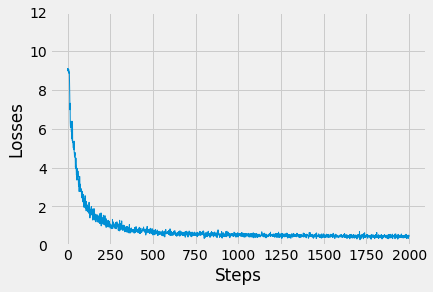

In [16]:
# plot losses

with plt.style.context('fivethirtyeight'):
    plt.plot(losses, linewidth = 1)
    plt.xlabel('Steps')
    plt.ylabel('Losses')
    plt.ylim((0, 12))

plt.show()

In [17]:
# let's test the model

with tf.Graph().as_default():
    
    # placeholders
    encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
    decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

    # output projection
    size = 512
    w_t = tf.get_variable('proj_w', [es_vocab_size, size], tf.float32)
    b = tf.get_variable('proj_b', [es_vocab_size], tf.float32)
    w = tf.transpose(w_t)
    output_projection = (w, b)
    
    # change the model so that output at time t can be fed as input at time t+1
    outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                                encoder_inputs,
                                                decoder_inputs,
                                                tf.contrib.rnn.BasicLSTMCell(size),
                                                num_encoder_symbols = en_vocab_size,
                                                num_decoder_symbols = es_vocab_size,
                                                embedding_size = 100,
                                                feed_previous = True, # <-----this is changed----->
                                                output_projection = output_projection,
                                                dtype = tf.float32)
    
    # ops for projecting outputs
    outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

    # let's translate these sentences     
    en_sentences = ["reboot the server", "What' s your name", 'My name is', 'What are you doing', 'I am reading a book',\
                    'How are you', 'I am good', 'Do you speak English', 'What time is it', 'Hi', 'Goodbye', 'Yes', 'No']
    en_sentences_encoded = [[en_word2idx.get(word, 0) for word in en_sentence.split()] for en_sentence in en_sentences]
    
    # padding to fit encoder input
    for i in range(len(en_sentences_encoded)):
        en_sentences_encoded[i] += (15 - len(en_sentences_encoded[i])) * [en_word2idx['<pad>']]
    
    # restore all variables - use the last checkpoint saved
    saver = tf.train.Saver()
    path = tf.train.latest_checkpoint('checkpoints')
    
    with tf.Session() as sess:
        # restore
        saver.restore(sess, path)
        
        # feed data into placeholders
        feed = {}
        for i in range(input_seq_len):
            feed[encoder_inputs[i].name] = np.array([en_sentences_encoded[j][i] for j in range(len(en_sentences_encoded))], dtype = np.int32)
            
        feed[decoder_inputs[0].name] = np.array([es_word2idx['<go>']] * len(en_sentences_encoded), dtype = np.int32)
        
        # translate
        output_sequences = sess.run(outputs_proj, feed_dict = feed)
        
        # decode seq.
        for i in range(len(en_sentences_encoded)):
            print '{}.\n--------------------------------'.format(i+1)
            ouput_seq = [output_sequences[j][i] for j in range(output_seq_len)]
            #decode output sequence
            words = decode_output(ouput_seq)
        
            print en_sentences[i]
            for i in range(len(words)):
                if words[i] not in ['<eos>', '<pad>', '<go>']:
                    print words[i],
            
            print '\n--------------------------------'

INFO:tensorflow:Restoring parameters from checkpoints/-9999
1.
--------------------------------
reboot the server
<ukn> la <ukn> 
--------------------------------
2.
--------------------------------
What' s your name
<ukn> en su nombre 
--------------------------------
3.
--------------------------------
My name is
Mi nombre es 
--------------------------------
4.
--------------------------------
What are you doing
¿Cuáles serían haciendo 
--------------------------------
5.
--------------------------------
I am reading a book
Soy que se <ukn> 
--------------------------------
6.
--------------------------------
How are you
¿Cómo se lo es 
--------------------------------
7.
--------------------------------
I am good
Soy buena 
--------------------------------
8.
--------------------------------
Do you speak English
¿Cree hablar de la inglés 
--------------------------------
9.
--------------------------------
What time is it
Lo que es el momento 
--------------------------------
10.
-